In [1]:
from __future__ import print_function, division
from scipy.io import loadmat,wavfile
from scipy.signal import decimate,butter
import os
import numpy as np
import matlab.engine
import matplotlib.pyplot as plt
from heartnet_v1 import heartnet

Using TensorFlow backend.


In [551]:
target_fs=1000;
nsamp=2500;
# file_path='/media/taufiq/Data/heart_sound/Heart_Sound/Physionet/training/training-a/a0002.wav'
# file_path='/media/taufiq/Data/heart_sound/Heart_Sound/Physionet/training/training-a/a0007.wav'
# file_path='/media/taufiq/Data/heart_sound/Heart_Sound/Physionet/training/training-b/b0018.wav'
# file_path='/media/taufiq/Data/heart_sound/Server/Heartnet/test.wav' #0.46955934
# file_path='/home/taufiq/Downloads/wavexports/1_sitting_aortic.wav' #0.50722462 
# file_path='/home/taufiq/Downloads/wavexports/1_sitting_mitral.wav' #0.51495665
# file_path='/home/taufiq/Downloads/wavexports/1_sitting_pulmonic.wav' #0.5808894
# file_path='/home/taufiq/Downloads/wavexports/1_sitting_tricuspid.wav' #0.65291744
# file_path='/home/taufiq/Downloads/wavexports/1_supine_aortic.wav' #0.69350135
# file_path='/home/taufiq/Downloads/wavexports/1_supine_mitral.wav' #0.72684127
# file_path='/home/taufiq/Downloads/wavexports/1_supine_pulmonic.wav' #0.85361111
# file_path='/home/taufiq/Downloads/wavexports/2_supine_mitral.wav' #0.80656379
# file_path='/home/taufiq/Downloads/wavexports/2_supine_ontheneck.wav' #0.79087454
# file_path='/home/taufiq/Downloads/wavexports/2_supine_pulmonic.wav' #0.73623508
file_path='/home/taufiq/Downloads/wavexports/2_supine_tricuspid.wav'
# file_path='/home/taufiq/Downloads/wavexports/3_supine_tricuspid.wav' #0.5242548
# file_path='/home/taufiq/Downloads/wavexports/3_supine_pulmonic.wav' #0.78235453
# file_path='/home/taufiq/Downloads/wavexports/3_supine_mitral.wav' #0.65459943
# file_ath = '/home/taufiq/Downloads/wavexports/3_sitting_mitral.wav'
# file_path='/home/taufiq/Downloads/wavexports/3_supine_aortic.wav'
load_path='/media/taufiq/Data/heart_sound/models/fold1_noFIR 2018-02-02 09:52:02.463256/weights.0148-0.8902.hdf5'
springer_path='/media/taufiq/Data/heart_sound/Heart_Sound/codes/cristhian.potes-204/'

## Start Matlab engine. Add path of the custom matlab functions

In [552]:
eng = matlab.engine.start_matlab()

In [553]:
eng.addpath('/media/taufiq/Data/heart_sound/Heart_Sound/codes/cristhian.potes-204/');

In [554]:
PCG,in_fs = eng.audioread(file_path,nargout=2)

## Pre-processing

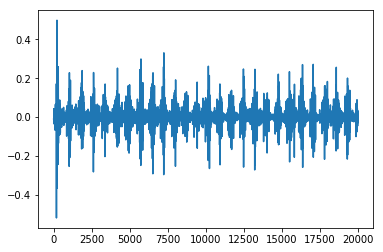

In [555]:
PCG = eng.resample(PCG,matlab.double([target_fs]),matlab.double([in_fs]))
PCG = eng.butterworth_low_pass_filter(PCG,matlab.double([2]),matlab.double([400]),matlab.double([1000]))
PCG = eng.butterworth_high_pass_filter(PCG,matlab.double([2]),matlab.double([25]),matlab.double([1000]))
PCG = eng.schmidt_spike_removal(PCG,matlab.double([target_fs]))
plt.plot(np.hstack(np.asarray(PCG)))
plt.show()

## Segmentation

In [556]:
assigned_states = eng.runSpringerSegmentationAlgorithmpython(PCG,matlab.double([target_fs]))
idx_states,last_idx=eng.get_states_python(assigned_states,nargout=2)

In [557]:
len(idx_states)

26

## Arranging the data for the keras model 

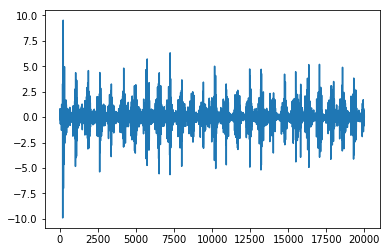

In [558]:
ncc=len(idx_states)
idx_states=np.hstack(np.asarray(idx_states))
idx_states=np.reshape(idx_states,(ncc,4))
idx_states=idx_states-1 ## -1 for python indexing compatibility 
PCG = np.hstack(np.asarray(PCG))
x = np.zeros([ncc,nsamp],dtype=np.double)
x.shape
PCG = PCG/np.std(PCG)
plt.plot(PCG)

In [559]:
for row in range(ncc):
    if row == ncc-1:
        tmp = PCG[int(idx_states[row,0]):int(last_idx-1)] ## 2 to compensate for python indexing
    else:
        tmp=PCG[int(idx_states[row,0]):int(idx_states[row+1,0]-1)]
    N = nsamp-tmp.shape[0]
    x[row,:] = np.concatenate((tmp,np.zeros(N)))
x = np.reshape(x,(x.shape[0],x.shape[1],1))

In [560]:
idx_states.shape

(26, 4)

## Plot some random cardiac cycles to see whether it is okay or not

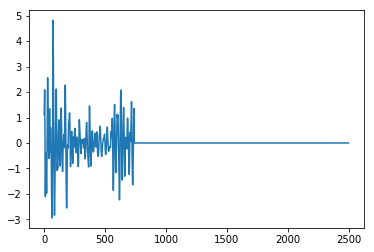

In [561]:
plt.plot(x[np.random.randint(1,x.shape[0])])
# plt.plot(x[0])
plt.show()

In [562]:
model=heartnet(load_path,'relu')

In [565]:
y_pred=model.predict(x)
print(y_pred)
if np.mean(y_pred)>.5:
    print("Abnormal")
else:
    print("Normal")

[[  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  3.45701636e-07]
 [  1.06970301e-26]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  7.51209126e-15]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  7.37099026e-06]
 [  9.11528409e-01]
 [  9.11528409e-01]
 [  1.02020140e-05]]
Abnormal


In [566]:
np.mean(y_pred)

0.73623508